In [1]:
import sys

sys.path.append("../")

import tensorflow as tf
import os

from collections import defaultdict
from scipy.signal import triang

from tensorflow.keras.models import load_model
from lib_dolphin.audio import *
from lib_dolphin.sequential import *
from lib_dolphin.eval import *
from lib_dolphin.discrete import *

FFT_STEP     = 128
FFT_WIN      = 512
FFT_HI       = 230
FFT_LO       = 100

D            = FFT_WIN // 2 - FFT_LO - (FFT_WIN // 2 - FFT_HI)

MODEL_PATH = '../../web_service/ml_models_v2/'

decoder       = load_model(f'{MODEL_PATH}/decoder_nn.h5', custom_objects = {'Functional' : tf.keras.models.Model})
lab           = pkl.load(open(f"{MODEL_PATH}/labels.pkl", "rb"))
reverse       = {v:k for k, v in lab.items()}
label_mapping = pkl.load(open(f'{MODEL_PATH}/label_mapping.pkl', 'rb'))

def spec(x):
    return spectrogram(x, FFT_LO, FFT_HI, FFT_WIN, FFT_STEP)            
        
def decode(x, decoder, label_mapping, reverse, smoothing=True, ignoire_echo=True):
    t, d = x.shape
    a = x.reshape((1,t,d,1))
    p = decoder.predict(a, verbose=0).reshape((a.shape[1], label_mapping.n + 1)) 

    if len(p) > NEURAL_SMOOTH_WIN and smoothing:
        for i in range(0, len(p[0])):
            window = triang(NEURAL_SMOOTH_WIN) / np.sum(triang(NEURAL_SMOOTH_WIN)) 
            p[:, i] = np.convolve(p[:, i], window, mode='same')
    p[:, 0] *= NEURAL_NOISE_DAMPENING
    for i in range(1, len(p[0])):
        dc = i2name(i, reverse, label_mapping)
        if dc in NEURAL_LABEL_DAMPENING:
            df = NEURAL_LABEL_DAMPENING[dc]
            #print(f" ... dampen {dc} by {df}")
            p[:, i] *= df
    
    local_c = p.argmax(axis=1)
    local_p = p.max(axis=1)                    
    local_c = [reject(local_c[i], local_p[i], NEURAL_REJECT[i2name(local_c[i], reverse, label_mapping)])
               for i in range(len(local_c))]
    return local_c, p, local_p

2023-02-18 22:19:57.721324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 22:19:58.307979: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-18 22:19:59.608522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-02-18 22:19:59.608668: W tensorflow/stream_executor/platform/default/dso_load

signals2.wav


/home/dkohlsdorf/Documents/wdp-ds/notebooks/../lib_dolphin/audio.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  x = read(path)[1]
2023-02-18 22:20:11.751361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


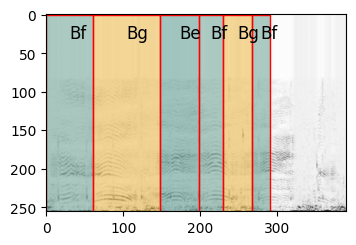

signals4.wav


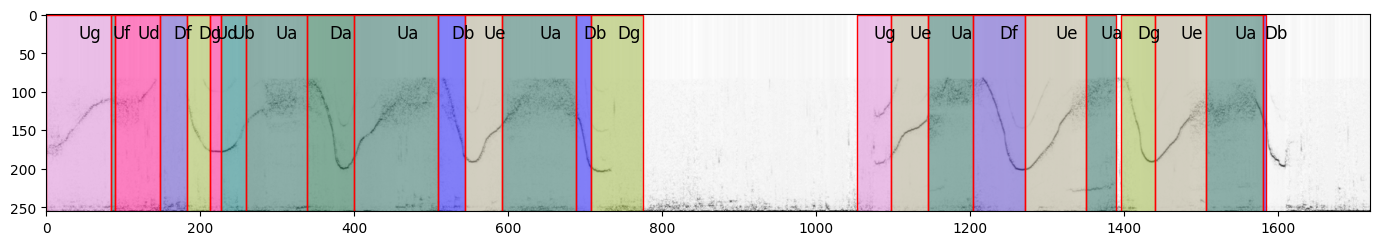

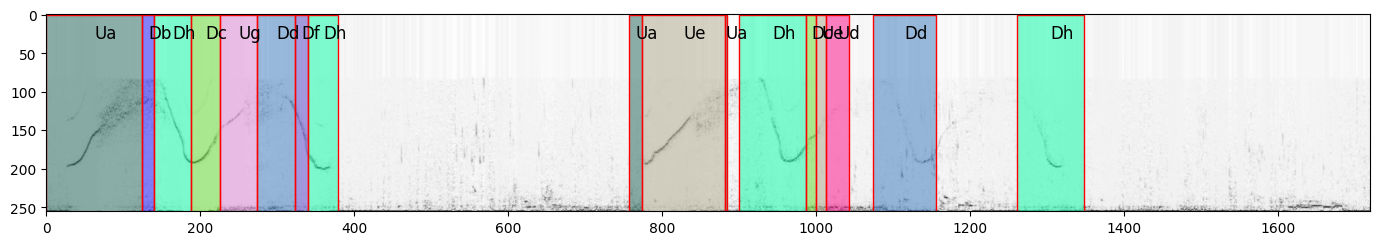


KeyboardInterrupt



<Figure size 640x480 with 0 Axes>

In [2]:
NEURAL_NOISE_DAMPENING=5.0
NEURAL_LABEL_DAMPENING={
    'Uc' : 0.1,
    'Ee' : 0.1,
    'Eb' : 0.1,
    'Eg' : 0.1,
    'Ed' : 0.1,
    'Ef' : 0.75,
    'Bc' : 0.75,
    'Be' : 0.75,    
    'Bf' : 0.75,
    'Bg' : 0.75,
}

NEURAL_REJECT= defaultdict(lambda: 0.1, {})
NEURAL_SMOOTH_WIN=128

PRINT_LAB = None
ONLY_HITS = False

path = '../../test_encode/partial/'
for file in os.listdir(path):
    if not file.startswith('.') and (file.endswith('.wav') or file.endswith('.WAV')):
        print(file)
        fp = f"{path}{file}"
        x = raw(fp)
        for i in range(0, len(x), 441000 // 2):        
            s = spec(x[i:i + 441000 // 2])        
            plottable = spectrogram(x[i:i + 441000 // 2], 0, FFT_WIN // 2, FFT_WIN, FFT_STEP)
            dec, _p, local_p  = decode(s, decoder, label_mapping, reverse)
            if PRINT_LAB is not None:
                for a, b in zip(dec, local_p):
                    if i2name(a, reverse, label_mapping).startswith(PRINT_LAB) or PRINT_LAB =='ALL':
                        print(f"\t{a} {b}")
            c    = compress_neural(dec, len(s), reverse, label_mapping)
            plot_neural(plottable, c, None)  


In [ ]:
bins = np.linspace(0, 0.2, 250)

for i in range(0, 32):
    dc = i2name(i, reverse, label_mapping)
    if dc.startswith('B'):
        x = p[i, :]
        x = x[x > 0]
        th = [1/33]
        plt.hist(x, bins, label=dc)
        plt.title(i2name(i, reverse,label_mapping))
plt.legend()
plt.show()



In [ ]:
for i in range(0, 33):
    print(i2name(i, reverse,label_mapping ))


In [ ]:
1/33